# Training procedure of GPR model for the enzymatic bromination reaction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading data, normalizing it and splitting it into X and y

In [4]:
data = pd.read_csv("reaction_conditions_from _sanyas_data_4_ML.csv")
# MES concentration constant -> delete
del data["MES"]
# Reaction conditions as X-values, normalized via MINMAX scaling
data_X = data.loc[:,"ACN":"t"]
MAX_X = data_X.max()
MIN_X = data_X.min()
data_X_norm = (data_X-MIN_X)/(MAX_X-MIN_X)
# Product fractions as y-values, normalized via MINMAX scaling
data_y = data.loc[:,"Fraction"]
MAX_y = data_y.max()
MIN_y = data_y.min()
data_y_norm = (data_y-MIN_y)/(MAX_y-MIN_y)

In [5]:
# Plot formatting 
size=16
params = {'legend.fontsize': 'large',
          'figure.figsize': (5,5),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 18}
plt.rcParams.update(params)

### Splitting data into test and train, train model, test model

SCORE: 0.9884426307369346
MAE: 0.0040097479391241145


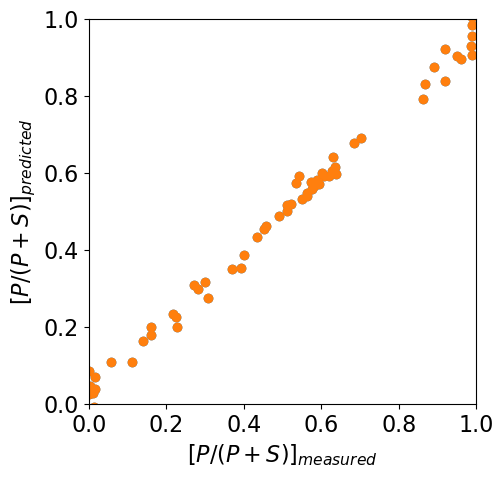

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern
from sklearn.model_selection import train_test_split

X=data_X_norm
y=data_y_norm

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=888)

kernel =  Matern(length_scale=0.0728, nu=1.5)
gpr = GaussianProcessRegressor(alpha=1e-12,kernel=kernel,
    random_state=154879).fit(X_train, y_train)
score = gpr.score(X_test, y_test)
print ("SCORE:",score)
Y_pred = gpr.predict(X_test,return_std=False)
MAE = (y_test-Y_pred).mean()
print ("MAE:",MAE)
plt.scatter(y_test,Y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")

plt.axis([0, 1, 0, 1])
plt.scatter(y_test,Y_pred)
plt.xlabel(r"$[P/(P+S)]_{measured}$")
plt.ylabel(r"$[P/(P+S)]_{predicted}$")
plt.show()

### Visualize model prediction, STDEV and actual meassured product fraction for testset

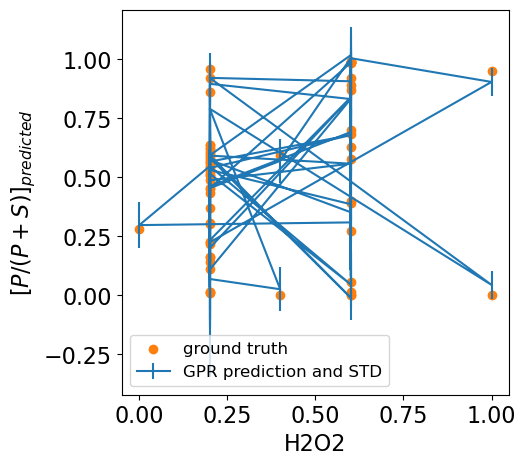

In [15]:
#for flow in ["ACN","Enzyme","Substrate","NH4Br","H2O2","Vanadat","t"]: 
for flow in ["H2O2"]: # replace line with line above to see plot for all reaction variables 
    plt.errorbar(X_test[flow], Y_pred[0],yerr=Y_pred[1],c="tab:blue",label="GPR prediction and STD")
    plt.scatter(X_test[flow], y_test,c="tab:orange",label="ground truth")
    plt.legend()
    #plt.scatter()
    plt.xlabel(flow)
    plt.ylabel(r"$[P/(P+S)]_{predicted}$")
    plt.show()

### Optimize yield or STDEV to make predictions

In [19]:
from scipy.optimize import differential_evolution

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def function(paras):
    Flow1,Flow2,Flow3,Flow4,Flow5,Flow6,Flow7= paras
    X=(Flow1,Flow2,Flow3,Flow4,Flow5,Flow6,Flow7)
    X= (X-MIN_X)/(MAX_X-MIN_X)
    X=np.reshape([X],(1,-1))
    Y, Y_STD = gpr.predict(X,return_std=True)
    return (-0*Y_STD-1*Y) # Function to be optimized, to optimize for either yield or STDEV 
# define bounds to search within 
bnds = ((0.4,0.5),(0.5,1),(10,10),(1,150),(1,30),(0,5),(0,175)) 
optim = differential_evolution(function,bnds)

opt = pd.DataFrame(optim.x.reshape(1,-1),columns=["ACN","Enzyme","Substrate","NH4Br","H2O2","Vanadat","t"])
print (opt)
X = optim.x
X = (X-MIN_X)/(MAX_X-MIN_X)
X=np.reshape([X],(1,-1))
Y, Y_STD = gpr.predict(X,return_std=True)
print ("predicted product fraction and STDEV",Y, Y_STD)

reaction conditions         ACN  Enzyme  Substrate      NH4Br  H2O2   Vanadat      t
0  0.402543     1.0       10.0  18.942248  30.0  1.006783  175.0
predicted product fraction and STDEV [0.77246381] [0.09235305]


/home/sc.uni-leipzig.de/tg042ztyo/.conda/envs/ML4EDA/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:1464: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


     ACN  Enzyme  Substrate     NH4Br  H2O2   Vanadat         t
68   0.0  0.0625        1.0  0.057692  0.20  0.428571  0.571429
213  1.0  0.0625        1.0  0.057692  0.60  0.428571  0.714286
179  0.0  0.0625        0.0  0.057692  0.04  0.428571  0.428571
106  0.0  0.0625        1.0  0.057692  0.00  0.428571  0.285714
235  0.0  0.5000        1.0  0.057692  0.60  0.428571  0.107143
..   ...     ...        ...       ...   ...       ...       ...
115  0.0  0.0625        1.0  0.057692  0.60  0.428571  0.428571
150  0.0  0.0000        1.0  0.057692  0.60  0.428571  0.857143
239  0.0  0.5000        1.0  0.057692  0.60  0.428571  0.250000
237  0.0  0.5000        1.0  0.057692  0.60  0.428571  0.178571
154  0.0  0.0000        1.0  0.057692  1.00  0.428571  0.285714

[184 rows x 7 columns]


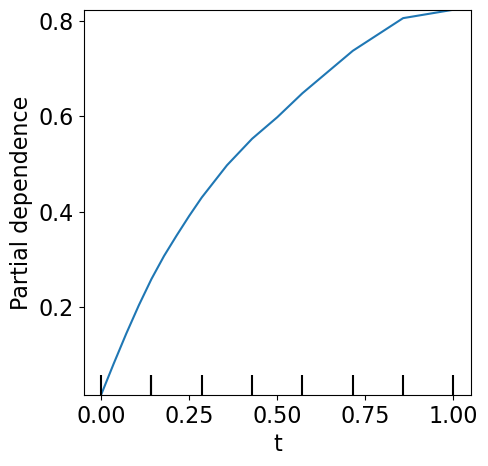

In [29]:
# Partial dependence plot
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

print (X_train)

features = ["t"]
plot_partial_dependence(gpr, X_train, features,
                        n_jobs=3, grid_resolution=20)

fig = plt.gcf()
plt.savefig("PDP_Enzyme_Gulder_rxn",dpi=300)